# 03 Convert Annotations from MD.AI to masks

In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.spatial import distance
from utils import visualize_reg_mask, create_mask, vertices_to_mask_slice, BB_multislice_to_mask, BB_and_markers_to_mask_1, BB_and_markers_to_mask_2

## Load in annotations

In [8]:
# read in csv with annotation data that was extracted from json in step 01
csv_filepath = '/data/larson2/RCC_dl/annotations/anon_metadata_annotations.csv'
anntn_df = pd.read_csv(csv_filepath)

In [9]:
base_dir = '/data/larson2/RCC_dl/data2022'

#gather annotations on the same series with the same type of annotation
uniqanntn = anntn_df.drop_duplicates(subset = ['StudyInstanceUID', 'SeriesInstanceUID', 'labelName'])
#uniqanntn.reset_index(inplace=True) #reset index after dropping duplicates

pids = os.listdir(base_dir) #use patients that we have noncon + phase info for (i.e. have a folder in /data2022)
print(len(pids))

842


## Automated/Looped: Convert all annotations to nifti masks

In [32]:
#cycle through patients
#PID = 'dMIr21n125' #for debugging
start = 0
end = 843

for i, PID in enumerate(pids[start:end]):
    print('----------------------index:', i+start, 'PID:', PID, '------------------------------')
    uniqanntn_pid= uniqanntn[uniqanntn['Patient ID'] == PID] 

    # cycle through phases
    phases = set([a['Phase Name'] for a in list(uniqanntn_pid.T.to_dict().values())])
    for phase in phases:
        annotations_list = uniqanntn_pid[uniqanntn_pid['Phase Name'] == phase]
        scan_numbers = set([a['SeriesInstanceUID'] for a in list(annotations_list.T.to_dict().values())])

        for scan_number in scan_numbers:
            annotations_list_2 = annotations_list[annotations_list['SeriesInstanceUID'] == scan_number]

            #load phase image
            nii_path = os.path.join(base_dir,PID,(phase+'.nii.gz'))
            if os.path.isfile(nii_path):
                nii_img = nib.load(nii_path)
                header = nii_img.header
            else:
                print('No phase nii:', phase, 'SeriesInstanceUID:', scan_number)
                continue

            #list out annotations for phase scan
            
            prone_bool = annotations_list_2['Prone'].iloc[0]
            labelnames = set([a['labelName'] for a in list(annotations_list_2.T.to_dict().values())])
            print(phase, scan_number, labelnames)
            if prone_bool:
                print('----------------- PRONE ------------------')

            if phase == 'noncon':
                option3_set = ['cen_top_noncon', 'cen_bot_concon', 'BB_R_noncon', 'BB_L_noncon' , 'BB_R_NC', 'BB_L_NC']
            elif phase == 'delay':
                option3_set = ['cen_top_del', 'cen_bot_del', 'BB_R_delay', 'BB_L_delay', 'BB_R_DEL', 'BB_L_DEL']
            elif phase == 'arterial':
                option3_set = ['cen_top_art', 'cen_bot_art', 'BB_R_arterial', 'BB_L_arterial', 'BB_R_ART', 'BB_L_ART']
            elif phase == 'portven':
                option3_set = ['cen_top_pv', 'cen_bot_pv', 'BB_R_portven', 'BB_L_portven', 'BB_R_PV', 'BB_L_PV']
            else:
                print('Error unknown phase', phase)

            if option3_set[0] in labelnames and (option3_set[-1] or option3_set[-2] or option3_set[-3] or option3_set[-4] in labelnames):
                upd_set = set(option3_set) & set(labelnames)

                # option 3 = center markers for top and bottom of mask and BB in center slice       
                curr_anntn = annotations_list_2[annotations_list_2['labelName'].isin(upd_set)]

                curr_anntn_list = anntn_df[(anntn_df['StudyInstanceUID'].values == curr_anntn['StudyInstanceUID'].iloc[0])\
                    & (anntn_df['SeriesInstanceUID'].values == curr_anntn['SeriesInstanceUID'].iloc[0])\
                        & (anntn_df['labelName'].isin(upd_set))]
                curr_anntn_list.reset_index(drop=True, inplace=True) #reset index after dropping duplicates

                #check if theres 2 annotations one for tumor on each side or if one
                num_markers = len(curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_top_')])
                if num_markers == 2:
                    print('2 masks needed')

                    # seperate left and right markers by computing euclidean distance between corner of BB and markers
                    BB_right_anntn = curr_anntn_list[curr_anntn_list['labelName'].str.contains('BB_R_')]
                    BB_lft_anntn = curr_anntn_list[curr_anntn_list['labelName'].str.contains('BB_L_')]
                    x_rt, y_rt = BB_right_anntn['data.y'], BB_right_anntn['data.x']
                    centop_anntns = curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_top_')]
                    cenbot_anntns = curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_bot_')]
                    xt, yt = centop_anntns['data.y'], centop_anntns['data.x']
                    xb, yb = cenbot_anntns['data.y'], cenbot_anntns['data.x']
                    
                    if distance.euclidean([x_rt,y_rt],[xt.iloc[0],yt.iloc[0]]) <= distance.euclidean([x_rt,y_rt],[xt.iloc[1],yt.iloc[1]]):
                        BB_right_anntn = BB_right_anntn.append(centop_anntns.iloc[0])
                        BB_lft_anntn = BB_lft_anntn.append(centop_anntns.iloc[1])
                    else:
                        BB_right_anntn = BB_right_anntn.append(centop_anntns.iloc[1])
                        BB_lft_anntn = BB_lft_anntn.append(centop_anntns.iloc[0])
                    if distance.euclidean([x_rt,y_rt],[xb.iloc[0],yb.iloc[0]]) <= distance.euclidean([x_rt,y_rt],[xb.iloc[1],yb.iloc[1]]):
                        BB_right_anntn = BB_right_anntn.append(cenbot_anntns.iloc[0])
                        BB_lft_anntn = BB_lft_anntn.append(cenbot_anntns.iloc[1])
                    else:
                        BB_right_anntn = BB_right_anntn.append(cenbot_anntns.iloc[1])
                        BB_lft_anntn = BB_lft_anntn.append(cenbot_anntns.iloc[0])

                    #create masks
                    #right first
                    name_rt = [i for i in upd_set if 'BB_R' in i][0]
                    output_filename_rt1 = os.path.join(base_dir,PID,(name_rt+'_markers_1.nii.gz'))
                    output_filename_rt2 = os.path.join(base_dir,PID,(name_rt+'_markers_2.nii.gz'))

                    #way 1
                    print(name_rt+'_markers_1')
                    create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, BB_right_anntn, header, output_filename_rt1, prone_bool, phase)
                    #way 2
                    print(name_rt+'_markers_2')
                    create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, BB_right_anntn, header, output_filename_rt2, prone_bool, phase)

                    #and left
                    name_lft = [i for i in upd_set if 'BB_L' in i][0]
                    output_filename_lft1 = os.path.join(base_dir,PID,(name_lft+'_markers_1.nii.gz'))
                    output_filename_lft2 = os.path.join(base_dir,PID,(name_lft+'_markers_2.nii.gz'))

                    #way 1
                    print(name_lft+'_markers_1')
                    create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, BB_lft_anntn, header, output_filename_lft1, prone_bool, phase)
                    #way 2
                    print(name_lft+'_markers_2')
                    create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, BB_lft_anntn, header, output_filename_lft2, prone_bool, phase)
                    
                elif num_markers == 1:
                    print('1 mask needed')
                    name = [i for i in upd_set if 'BB' in i][0]
                    output_filename_1 = os.path.join(base_dir,PID,(name+'_markers_1.nii.gz'))
                    output_filename_2 = os.path.join(base_dir,PID,(name+'_markers_2.nii.gz'))

                    #way 1
                    print(name+'_markers_1')
                    create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, curr_anntn_list, header, output_filename_1, prone_bool, phase)
                    #way 2
                    print(name+'_markers_2')
                    create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, curr_anntn_list, header, output_filename_2, prone_bool, phase)

                else:
                    print('more than 2 cen_top markers')
                
                #remove from list
                labelnames = set(labelnames) - set(upd_set)
            
            # cycle through each annotation
            for annotation in labelnames:
                curr_anntn = annotations_list_2[annotations_list_2['labelName'].values == annotation]

                curr_anntn_list = anntn_df[(anntn_df['StudyInstanceUID'].values == curr_anntn['StudyInstanceUID'].values)\
                    & (anntn_df['SeriesInstanceUID'].values == curr_anntn['SeriesInstanceUID'].values)\
                        & (anntn_df['labelName'].values == curr_anntn['labelName'].values)]
                curr_anntn_list.reset_index(drop=True, inplace=True) #reset index after dropping duplicates

                if annotation == 'tumor':
                    filename = annotation + '_' + phase + '.nii.gz'
                else:
                    filename = annotation+'.nii.gz'
                output_filename = os.path.join(base_dir,PID,filename)

                print(annotation)
                if ~np.isnan(curr_anntn_list['data.width'][0]): #if has width, assume multislice BB (option 2)
                    create_mask(BB_multislice_to_mask, nii_img, nii_path, curr_anntn_list, header, output_filename, prone_bool, phase)    
                else: #if vertices, assume polygon (option 1)
                    create_mask(vertices_to_mask_slice, nii_img, nii_path, curr_anntn_list, header, output_filename, prone_bool, phase)

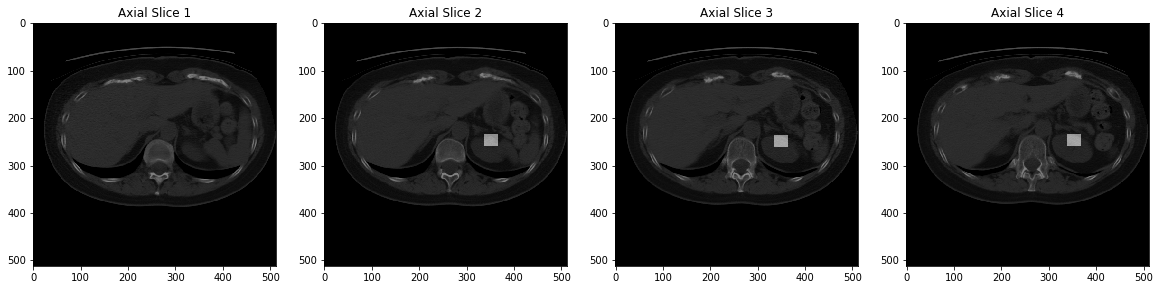

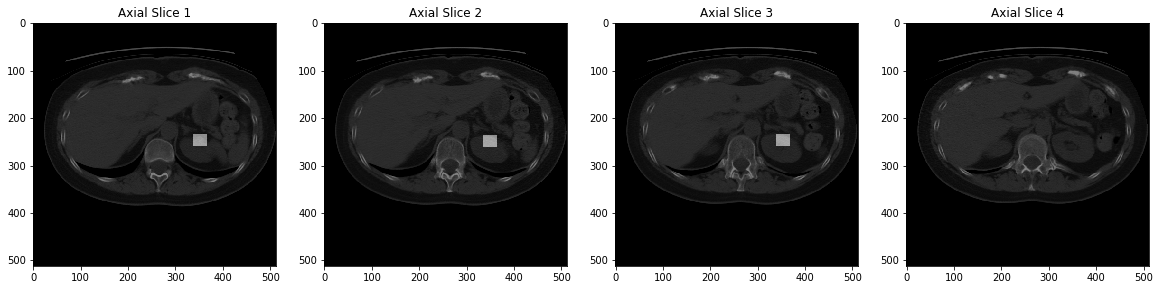

In [92]:
# QC by plotting some examples

nii_path = '/data/larson2/RCC_dl/data2022/Q5hPqtDCir/noncon.nii.gz'
#mask_path = '/data/larson2/RCC_dl/data2022/Wmbjh4OdZp/BB_R_noncon_markers_1.nii.gz'
mask_path = '/data/larson2/RCC_dl/data2022/Q5hPqtDCir/BB_L_noncon_markers_1.nii.gz'

#visualize_reg_mask(nii_path, mask_path, [0, 1, 2, 3])
visualize_reg_mask(nii_path, mask_path, [68, 67, 66, 65])
visualize_reg_mask(nii_path, mask_path, [67, 66, 65, 64])





## Fix cases that failed
111 cases had some sort of error

### One phase at a time

In [ ]:

PID = 'AjyTZDJQaK' 
phase = 'portven'
scan_number = '1.3.6.1.4.1.20319.142281825628140054978596436060138619143'  #SeriesInstanceUID
uniqanntn_pid= uniqanntn[uniqanntn['Patient ID'] == PID] 
annotations_list = uniqanntn_pid[uniqanntn_pid['Phase Name'] == phase]
annotations_list_2 = annotations_list[annotations_list['SeriesInstanceUID'] == scan_number]

#load phase image
nii_path = os.path.join(base_dir,PID,(phase+'.nii.gz'))
if os.path.isfile(nii_path):
    nii_img = nib.load(nii_path)
    header = nii_img.header
else:
    print('No phase nii:', phase, 'SeriesInstanceUID:', scan_number)
    exit

#list out annotations for phase scan
prone_bool = annotations_list_2['Prone'].iloc[0]
labelnames = set([a['labelName'] for a in list(annotations_list_2.T.to_dict().values())])
print(phase, scan_number, labelnames)
if prone_bool:
    print('----------------- PRONE ------------------')

if phase == 'noncon':
    option3_set = ['cen_top_noncon', 'cen_bot_concon', 'BB_R_noncon', 'BB_L_noncon' , 'BB_R_NC', 'BB_L_NC']
elif phase == 'delay':
    option3_set = ['cen_top_del', 'cen_bot_del', 'BB_R_delay', 'BB_L_delay', 'BB_R_DEL', 'BB_L_DEL']
elif phase == 'arterial':
    option3_set = ['cen_top_art', 'cen_bot_art', 'BB_R_arterial', 'BB_L_arterial', 'BB_R_ART', 'BB_L_ART']
elif phase == 'portven':
    option3_set = ['cen_top_pv', 'cen_bot_pv', 'BB_R_portven', 'BB_L_portven', 'BB_R_PV', 'BB_L_PV']
else:
    print('Error unknown phase', phase)

if option3_set[0] in labelnames and (option3_set[-1] or option3_set[-2] or option3_set[-3] or option3_set[-4] in labelnames):
    upd_set = set(option3_set) & set(labelnames)

    # option 3       
    curr_anntn = annotations_list_2[annotations_list_2['labelName'].isin(upd_set)]

    curr_anntn_list = anntn_df[(anntn_df['StudyInstanceUID'].values == curr_anntn['StudyInstanceUID'].iloc[0])\
        & (anntn_df['SeriesInstanceUID'].values == curr_anntn['SeriesInstanceUID'].iloc[0])\
            & (anntn_df['labelName'].isin(upd_set))]
    curr_anntn_list.reset_index(drop=True, inplace=True) #reset index after dropping duplicates

    #check if theres 2 one for tumor on each side or if one
    num_markers = len(curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_top_')])
    if num_markers == 2:
        print('2 masks needed')

        # seperate left and right markers by computing euclidean distance between corner of BB and markers
        BB_right_anntn = curr_anntn_list[curr_anntn_list['labelName'].str.contains('BB_R_')]
        BB_lft_anntn = curr_anntn_list[curr_anntn_list['labelName'].str.contains('BB_L_')]
        x_rt, y_rt = BB_right_anntn['data.y'], BB_right_anntn['data.x']
        centop_anntns = curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_top_')]
        cenbot_anntns = curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_bot_')]
        xt, yt = centop_anntns['data.y'], centop_anntns['data.x']
        xb, yb = cenbot_anntns['data.y'], cenbot_anntns['data.x']
        
        print(x_rt, y_rt)
        print(xt.iloc[0], yt.iloc[0])
        print(xt.iloc[1], yt.iloc[1])
        print(xb.iloc[0], yb.iloc[0])
        print(xb.iloc[1], yb.iloc[1])
        if distance.euclidean([x_rt,y_rt],[xt.iloc[0],yt.iloc[0]]) <= distance.euclidean([x_rt,y_rt],[xt.iloc[1],yt.iloc[1]]):
            BB_right_anntn = BB_right_anntn.append(centop_anntns.iloc[0])
            BB_lft_anntn = BB_lft_anntn.append(centop_anntns.iloc[1])
        else:
            BB_right_anntn = BB_right_anntn.append(centop_anntns.iloc[1])
            BB_lft_anntn = BB_lft_anntn.append(centop_anntns.iloc[0])
        if distance.euclidean([x_rt,y_rt],[xb.iloc[0],yb.iloc[0]]) <= distance.euclidean([x_rt,y_rt],[xb.iloc[1],yb.iloc[1]]):
            BB_right_anntn = BB_right_anntn.append(cenbot_anntns.iloc[0])
            BB_lft_anntn = BB_lft_anntn.append(cenbot_anntns.iloc[1])
        else:
            BB_right_anntn = BB_right_anntn.append(cenbot_anntns.iloc[1])
            BB_lft_anntn = BB_lft_anntn.append(cenbot_anntns.iloc[0])

        #create masks
        #right first
        name_rt = [i for i in upd_set if 'BB_R' in i][0]
        output_filename_rt1 = os.path.join(base_dir,PID,(name_rt+'_markers_1.nii.gz'))
        output_filename_rt2 = os.path.join(base_dir,PID,(name_rt+'_markers_2.nii.gz'))

        #way 1
        print(name_rt+'_markers_1')
        create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, BB_right_anntn, header, output_filename_rt1, prone_bool, phase)
        #way 2
        print(name_rt+'_markers_2')
        create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, BB_right_anntn, header, output_filename_rt2, prone_bool, phase)

        #and left
        name_lft = [i for i in upd_set if 'BB_L' in i][0]
        output_filename_lft1 = os.path.join(base_dir,PID,(name_lft+'_markers_1.nii.gz'))
        output_filename_lft2 = os.path.join(base_dir,PID,(name_lft+'_markers_2.nii.gz'))

        #way 1
        print(name_lft+'_markers_1')
        create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, BB_lft_anntn, header, output_filename_lft1, prone_bool, phase)
        #way 2
        print(name_lft+'_markers_2')
        create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, BB_lft_anntn, header, output_filename_lft2, prone_bool, phase)
        
    elif num_markers == 1:
        print('1 mask needed')
        name = [i for i in upd_set if 'BB' in i][0]
        output_filename_1 = os.path.join(base_dir,PID,(name+'_markers_1.nii.gz'))
        output_filename_2 = os.path.join(base_dir,PID,(name+'_markers_2.nii.gz'))

        #way 1
        print(name+'_markers_1')
        create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, curr_anntn_list, header, output_filename_1, prone_bool, phase)
        #way 2
        print(name+'_markers_2')
        create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, curr_anntn_list, header, output_filename_2, prone_bool, phase)

    else:
        print('more than 2 cen_top markers')
    
    #remove from list
    labelnames = set(labelnames) - set(upd_set)

# cycle through each annotation
for annotation in labelnames:
    curr_anntn = annotations_list_2[annotations_list_2['labelName'].values == annotation]

    curr_anntn_list = anntn_df[(anntn_df['StudyInstanceUID'].values == curr_anntn['StudyInstanceUID'].values)\
        & (anntn_df['SeriesInstanceUID'].values == curr_anntn['SeriesInstanceUID'].values)\
            & (anntn_df['labelName'].values == curr_anntn['labelName'].values)]
    curr_anntn_list.reset_index(drop=True, inplace=True) #reset index after dropping duplicates

    if annotation == 'tumor':
        filename = annotation + '_' + phase + '.nii.gz'
    else:
        filename = annotation+'.nii.gz'
    output_filename = os.path.join(base_dir,PID,filename)

    print(annotation)
    if ~np.isnan(curr_anntn_list['data.width'][0]): #if has width, assume multislice BB (option 2)
        create_mask(BB_multislice_to_mask, nii_img, nii_path, curr_anntn_list, header, output_filename, prone_bool, phase)    
    else: #if vertices polygon (option 1)
        create_mask(vertices_to_mask_slice, nii_img, nii_path, curr_anntn_list, header, output_filename, prone_bool, phase)

### one annotation at a time (multislice BB or tumor)

In [ ]:
PID = 'EZs1bOLKQW' 
phase = 'portven'
scan_number = '1.3.6.1.4.1.20319.215919274003024016538528899553092718771'
annotation = 'right_kidney_pv'

uniqanntn_pid= uniqanntn[uniqanntn['Patient ID'] == PID] 
annotations_list = uniqanntn_pid[uniqanntn_pid['Phase Name'] == phase]
annotations_list_2 = annotations_list[annotations_list['SeriesInstanceUID'] == scan_number]

#load phase image
nii_path = os.path.join(base_dir,PID,(phase+'.nii.gz'))
if os.path.isfile(nii_path):
    nii_img = nib.load(nii_path)
    header = nii_img.header
else:
    print('No phase nii:', phase, 'SeriesInstanceUID:', scan_number)
    exit

#list out annotations for phase scan
prone_bool = annotations_list_2['Prone'].iloc[0]
labelnames = set([a['labelName'] for a in list(annotations_list_2.T.to_dict().values())])
print(phase, scan_number, labelnames)
if prone_bool:
    print('----------------- PRONE ------------------')


curr_anntn = annotations_list_2[annotations_list_2['labelName'].values == annotation]

curr_anntn_list = anntn_df[(anntn_df['StudyInstanceUID'].values == curr_anntn['StudyInstanceUID'].values)\
    & (anntn_df['SeriesInstanceUID'].values == curr_anntn['SeriesInstanceUID'].values)\
        & (anntn_df['labelName'].values == curr_anntn['labelName'].values)]
curr_anntn_list.reset_index(drop=True, inplace=True) #reset index after dropping duplicates

if annotation == 'tumor':
    filename = annotation + '_' + phase + '.nii.gz'
else:
    filename = annotation+'.nii.gz'
output_filename = os.path.join(base_dir,PID,filename)

print(annotation)
if ~np.isnan(curr_anntn_list['data.width'][0]): #if has width, assume multislice BB (option 2)
    create_mask(BB_multislice_to_mask, nii_img, nii_path, curr_anntn_list, header, output_filename, prone_bool, phase)    
else: #if vertices polygon (option 1)
    create_mask(vertices_to_mask_slice, nii_img, nii_path, curr_anntn_list, header, output_filename, prone_bool, phase)

### One phase at a time and change name of annotations

In [75]:

PID = 'Q5hPqtDCir' 
phase = 'noncon'
scan_number = '1.3.6.1.4.1.20319.151555598637476211852075992246402826919'  #SeriesInstanceUID
uniqanntn_pid= uniqanntn[uniqanntn['Patient ID'] == PID] 
annotations_list = uniqanntn_pid[uniqanntn_pid['Phase Name'] == phase]
annotations_list_2 = annotations_list[annotations_list['SeriesInstanceUID'] == scan_number]

#load phase image
nii_path = os.path.join(base_dir,PID,(phase+'.nii.gz'))
#nii_path = os.path.join(base_dir,PID,'delay.nii.gz')
if os.path.isfile(nii_path):
    nii_img = nib.load(nii_path)
    header = nii_img.header
else:
    print('No phase nii:', phase, 'SeriesInstanceUID:', scan_number)
    exit

#list out annotations for phase scan
prone_bool = annotations_list_2['Prone'].iloc[0]
labelnames = set([a['labelName'] for a in list(annotations_list_2.T.to_dict().values())])
print(phase, scan_number, labelnames)
if prone_bool:
    print('----------------- PRONE ------------------')



noncon 1.3.6.1.4.1.20319.151555598637476211852075992246402826919 {'BB_L_delay', 'cen_bot_concon', 'cen_top_noncon'}


In [76]:
curr_anntn = annotations_list_2

curr_anntn_list = anntn_df[(anntn_df['StudyInstanceUID'].values == curr_anntn['StudyInstanceUID'].iloc[0])\
        & (anntn_df['SeriesInstanceUID'].values == curr_anntn['SeriesInstanceUID'].iloc[0])]
curr_anntn_list.reset_index(drop=True, inplace=True) #reset index after dropping duplicates
print(curr_anntn_list[['labelName', 'Instance Number', 'data.x', 'data.y']])

        labelName  Instance Number      data.x      data.y
0      BB_L_delay               12  350.024340  303.489860
1  cen_top_noncon               11  361.274569  312.916633
2  cen_bot_concon               13  355.262410  312.916633


In [77]:
#curr_anntn_list = curr_anntn_list.drop([0])
curr_anntn_list.at[1, 'labelName'] = 'cen_top_del'
curr_anntn_list.at[2, 'labelName'] = 'cen_bot_del'
#curr_anntn_list.at[7, 'labelName'] = 'BB_L_noncon'
print(curr_anntn_list[['labelName', 'Instance Number', 'data.x', 'data.y']])

     labelName  Instance Number      data.x      data.y
0   BB_L_delay               12  350.024340  303.489860
1  cen_top_del               11  361.274569  312.916633
2  cen_bot_del               13  355.262410  312.916633


1 mask needed
BB_L_delay_markers_1
312.023185 358.186665 64
312.916632981916 361.2745694601657 65
312.916632981916 355.26241025344603 63
[64, 65, 66, 67]


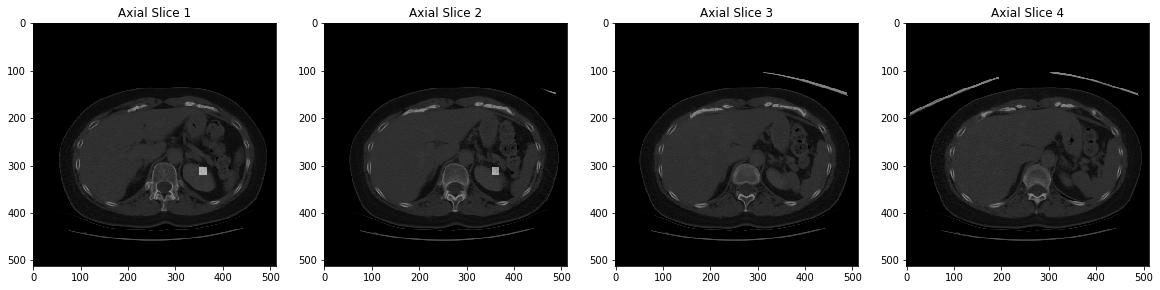

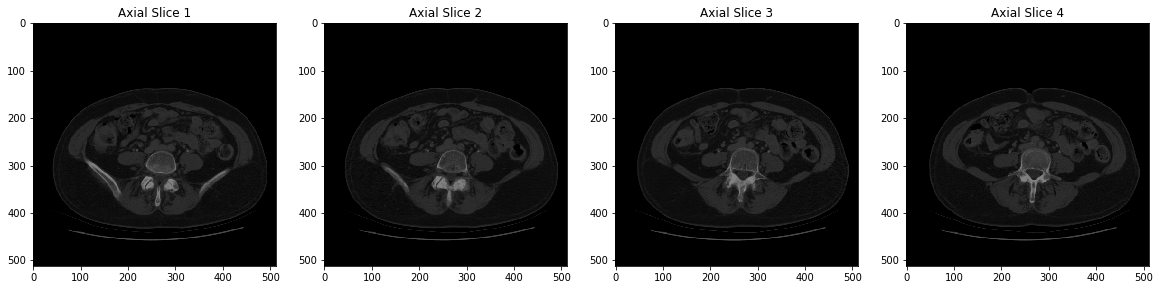

In [78]:
#check if theres 2 one for tumor on each side or if one
num_markers = len(curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_top_')])
if num_markers == 2:
    print('2 masks needed')

    # seperate left and right markers by computing euclidean distance between corner of BB and markers
    BB_right_anntn = curr_anntn_list[curr_anntn_list['labelName'].str.contains('BB_R_')]
    BB_lft_anntn = curr_anntn_list[curr_anntn_list['labelName'].str.contains('BB_L_')]
    x_rt, y_rt = BB_right_anntn['data.y'], BB_right_anntn['data.x']
    centop_anntns = curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_top_')]
    cenbot_anntns = curr_anntn_list[curr_anntn_list['labelName'].str.contains('cen_bot_')]
    xt, yt = centop_anntns['data.y'], centop_anntns['data.x']
    xb, yb = cenbot_anntns['data.y'], cenbot_anntns['data.x']
    
    #print(x_rt, y_rt)
    #print(xt.iloc[0], yt.iloc[0])
    #print(xt.iloc[1], yt.iloc[1])
    #print(xb.iloc[0], yb.iloc[0])
    #print(xb.iloc[1], yb.iloc[1])
    if distance.euclidean([x_rt,y_rt],[xt.iloc[0],yt.iloc[0]]) <= distance.euclidean([x_rt,y_rt],[xt.iloc[1],yt.iloc[1]]):
        BB_right_anntn = BB_right_anntn.append(centop_anntns.iloc[0])
        BB_lft_anntn = BB_lft_anntn.append(centop_anntns.iloc[1])
    else:
        BB_right_anntn = BB_right_anntn.append(centop_anntns.iloc[1])
        BB_lft_anntn = BB_lft_anntn.append(centop_anntns.iloc[0])
    if distance.euclidean([x_rt,y_rt],[xb.iloc[0],yb.iloc[0]]) <= distance.euclidean([x_rt,y_rt],[xb.iloc[1],yb.iloc[1]]):
        BB_right_anntn = BB_right_anntn.append(cenbot_anntns.iloc[0])
        BB_lft_anntn = BB_lft_anntn.append(cenbot_anntns.iloc[1])
    else:
        BB_right_anntn = BB_right_anntn.append(cenbot_anntns.iloc[1])
        BB_lft_anntn = BB_lft_anntn.append(cenbot_anntns.iloc[0])

    #create masks
    #right first
    name_rt = [i for i in labelnames if 'BB_R' in i][0]
    output_filename_rt1 = os.path.join(base_dir,PID,(name_rt+'_markers_1.nii.gz'))
    output_filename_rt2 = os.path.join(base_dir,PID,(name_rt+'_markers_2.nii.gz'))

    #way 1
    print(name_rt+'_markers_1')
    create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, BB_right_anntn, header, output_filename_rt1, prone_bool, phase)
    #way 2
    print(name_rt+'_markers_2')
    create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, BB_right_anntn, header, output_filename_rt2, prone_bool, phase)

    #and left
    name_lft = [i for i in labelnames if 'BB_L' in i][0]
    output_filename_lft1 = os.path.join(base_dir,PID,(name_lft+'_markers_1.nii.gz'))
    output_filename_lft2 = os.path.join(base_dir,PID,(name_lft+'_markers_2.nii.gz'))

    #way 1
    print(name_lft+'_markers_1')
    create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, BB_lft_anntn, header, output_filename_lft1, prone_bool, phase)
    #way 2
    print(name_lft+'_markers_2')
    create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, BB_lft_anntn, header, output_filename_lft2, prone_bool, phase)
    
elif num_markers == 1:
    print('1 mask needed')
    name = [i for i in labelnames if 'BB' in i][0]
    output_filename_1 = os.path.join(base_dir,PID,(name+'_markers_1.nii.gz'))
    output_filename_2 = os.path.join(base_dir,PID,(name+'_markers_2.nii.gz'))

    #way 1
    print(name+'_markers_1')
    create_mask(BB_and_markers_to_mask_1, nii_img, nii_path, curr_anntn_list, header, output_filename_1, prone_bool, phase)
    #way 2
    print(name+'_markers_2')
    create_mask(BB_and_markers_to_mask_2, nii_img, nii_path, curr_anntn_list, header, output_filename_2, prone_bool, phase)

else:
    print('more than 2 cen_top markers')
    

### Combine masks together

In [ ]:
pid = '78CsnJ4RVm'
base_dir ='/data/larson2/RCC_dl/data2022/'
path1 = os.path.join(base_dir, pid,'BB_L_noncon_markers_t1_1.nii.gz')
path2 = os.path.join(base_dir, pid,'BB_L_noncon_markers_t2_1.nii.gz')
path3 = os.path.join(base_dir, pid,'BB_L_noncon_markers_t3_1.nii.gz')
new_path = os.path.join(base_dir, pid,'BB_L_noncon_markers_1.nii.gz')

img1 = nib.load(path1)
img_data1 = img1.get_fdata()

img2 = nib.load(path2)
img_data2 = img2.get_fdata()

img3 = nib.load(path3)
img_data3 = img3.get_fdata()

new_img_data = img_data1 + img_data2 + img_data3

new_img = nib.Nifti1Image(new_img_data, affine=img1.affine, header=img1.header) #save rotated image with previous header info
nib.save(new_img, new_path)
